In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import torch
import os

from helpers.composite_helpers import *


from numba import cuda 


In [2]:


"""
"""
"""
COMPUTING PARAMETERS
"""
"""
"""

os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

torch.manual_seed(8)
np.random.seed(8)


Using device: cuda


In [3]:
"""
"""
"""
RUN PARAMETERS
"""
"""
"""

# directories

curtains_dir = "/global/home/users/rrmastandrea/curtains/fresh/"

n_points = 100000
n_features = 5
dataset_config_string = f"LHCO_minmax_new/"

exp_dir = os.path.join(curtains_dir, dataset_config_string)
data_dir = os.path.join(curtains_dir, dataset_config_string, "data")

print("Making results directory at", exp_dir, "...")
os.makedirs(exp_dir, exist_ok=True)

data_dir = os.path.join(exp_dir, "data")


# dataset generation parameters
context_endpoints = (3000, 4000)


bands_dict = {"ob1": [3000, 3200],
              "sb1": [3200, 3400],
              "sr" : [3400, 3600],
              "sb2": [3600, 3800],
              "ob2": [3800, 4000]}

binning_scheme = np.linspace(-4, 4, 50)


Making results directory at /global/home/users/rrmastandrea/curtains/fresh/LHCO_minmax_new/ ...


In [4]:
"""
"""
"""
LOAD IN THE DATASETS AND PROCESS
"""
"""
"""

dataset_sim = ToyDataset(data_dir, "data_sim.npy")
dataset_dat = ToyDataset(data_dir, "data_dat.npy")
               

print("Num SIM events:", len(dataset_sim))
print("Num DAT events:", len(dataset_dat))
print()

# Pull data from SB1 + SB2
training_dataset_sim = dataset_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
training_dataset_dat = dataset_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])

print("SIM sb1 + sb2 shape:", len(training_dataset_sim))
print("DAT sb1 + sb2 shape:", len(training_dataset_dat))
print()

# Preprocess the data
print("Preproccessing data...")
print()
training_dataset_sim.minmaxscale()
training_dataset_dat.minmaxscale()


# split into train val
val_split = 0.2

sim_val_size = int(val_split * len(training_dataset_sim))
dat_val_size = int(val_split * len(training_dataset_dat))

sim_train_size = len(training_dataset_sim) - sim_val_size
dat_train_size = len(training_dataset_dat) - dat_val_size


sim_train_dataset, sim_val_dataset = torch.utils.data.random_split(training_dataset_sim, [sim_train_size, sim_val_size])
dat_train_dataset, dat_val_dataset = torch.utils.data.random_split(training_dataset_dat, [dat_train_size, dat_val_size])

Num SIM events: 999986
Num DAT events: 999881

SIM sb1 + sb2 shape: 124815
DAT sb1 + sb2 shape: 124562

Preproccessing data...



In [5]:

"""
"
"
LOAD BASE DENSITY
"
"
"""

# Training the BD
# This will be the upper subdirectory in saved_models/

num_layers_BD = 8
num_hidden_features_BD = 64
hyperparameters_dict_BD = {"n_epochs": 50,
                          "batch_size": 128,
                          "lr": 0.0001,
                          "weight_decay": 0.001}

exp_id_BD = f"Masked_PRQ_AR_{num_layers_BD}layers_{num_hidden_features_BD}hidden_LRCos" # to distingush the saved models

# Define a flow architecture
transforms_BD = make_masked_AR_flow(num_layers_BD, n_features, num_hidden_features_BD)
base_dist = ConditionalDiagonalNormal(shape=[n_features], context_encoder=nn.Linear(1, 2*n_features))



"""
"
"
LOAD SIM -> DAT
"
"
"""

# Training s2d
# This will be another (of many) subdirectory in saved_models/

num_layers_s2d = 2
num_blocks_s2d = 8
num_nodes_s2d = 32
exp_id_s2d = f"PRQ_Coupling_{num_layers_s2d}layers_{num_blocks_s2d}blocks_{num_nodes_s2d}nodes_LRCos" # to distingush the saved models
transforms_s2d = make_coupling_flow(num_layers_s2d, n_features, num_nodes_s2d, num_blocks = num_blocks_s2d)


hyperparameters_dict_s2d = {"n_epochs": 50,
                          "batch_size": 256,
                          "lr": 0.0002,
                          "weight_decay": 0.0001}

In [6]:

# Load in BD and s2d models
config_string_BD = "epochs{0}_lr{1}_wd{2}_bs{3}".format(hyperparameters_dict_BD["n_epochs"], hyperparameters_dict_BD["lr"], hyperparameters_dict_BD["weight_decay"], hyperparameters_dict_BD["batch_size"])
config_string_s2d = "epochs{0}_lr{1}_wd{2}_bs{3}".format(hyperparameters_dict_s2d["n_epochs"], hyperparameters_dict_s2d["lr"], hyperparameters_dict_s2d["weight_decay"], hyperparameters_dict_s2d["batch_size"])


BD_dir = os.path.join(exp_dir, f"saved_models_{exp_id_BD}/")
checkpoint_path_BD = os.path.join(BD_dir, f"BDSIM_{config_string_BD}")


s2d_dir = os.path.join(BD_dir, f"saved_models_{exp_id_s2d}/")

checkpoint_path_s2d = os.path.join(s2d_dir, f"TRANS_{config_string_s2d}")

print("Loading the models ...")
print()
flow_BD = torch.load(f"{checkpoint_path_BD}_best_model.pt")
flow_s2d = torch.load(f"{checkpoint_path_s2d}_best_model.pt")

# send networks to device
flow_BD.to(device)
flow_s2d.to(device)

# freeze the trained models
for param in flow_BD.parameters():
    param.requires_grad = False
flow_BD.eval()

for param in flow_s2d.parameters():
    param.requires_grad = False
flow_s2d.eval()


Loading the models ...



Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): dense_net(
          (context_layer): Linear(in_features=1, out_features=32, bias=True)
          (functions): ModuleList(
            (0): Linear(in_features=2, out_features=32, bias=True)
            (1): Linear(in_features=32, out_features=32, bias=True)
            (2): Linear(in_features=32, out_features=32, bias=True)
            (3): Linear(in_features=32, out_features=32, bias=True)
            (4): Linear(in_features=32, out_features=32, bias=True)
            (5): Linear(in_features=32, out_features=32, bias=True)
            (6): Linear(in_features=32, out_features=32, bias=True)
            (7): Linear(in_features=32, out_features=32, bias=True)
            (8): Linear(in_features=32, out_features=87, bias=True)
          )
          (output_activ): Identity()
        )
      )
      (1): ReversePermutation()
      (2): Pi

Making samples for band ob1 ...
Making samples for band sb1 ...
Making samples for band sr ...
Making samples for band sb2 ...
Making samples for band ob2 ...


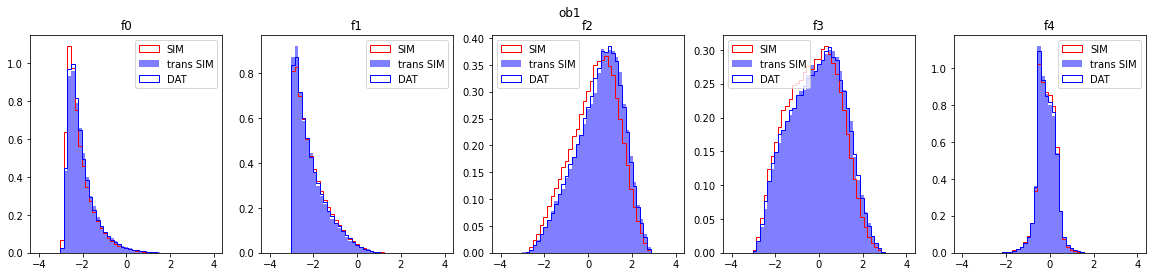

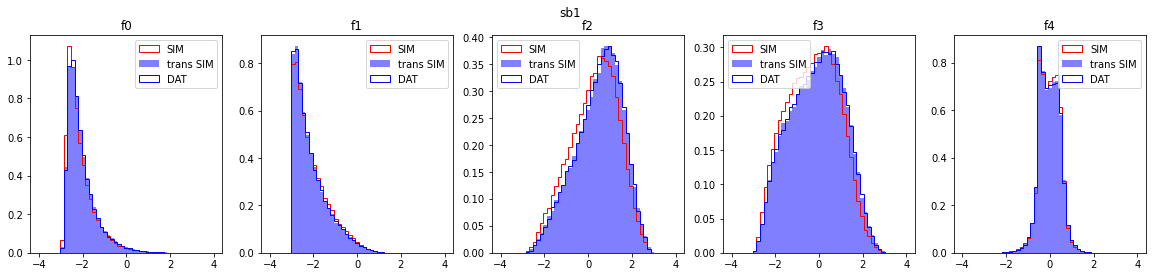

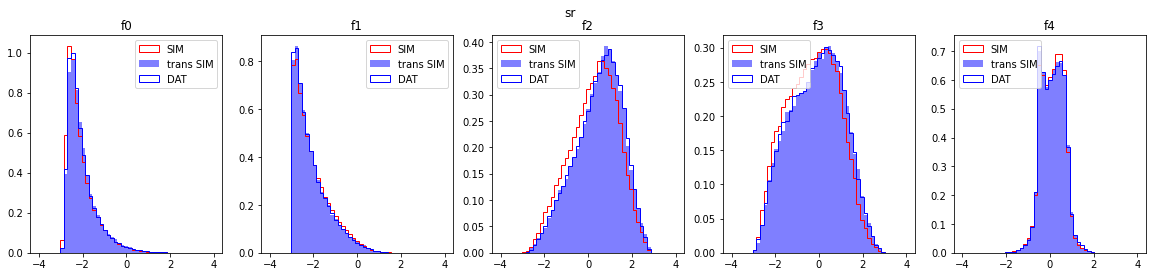

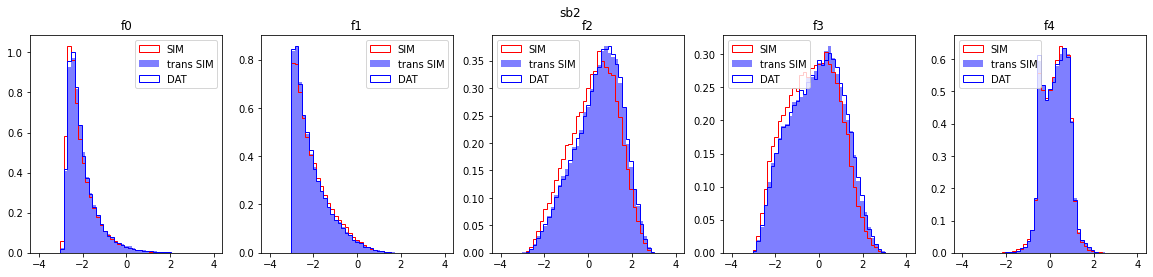

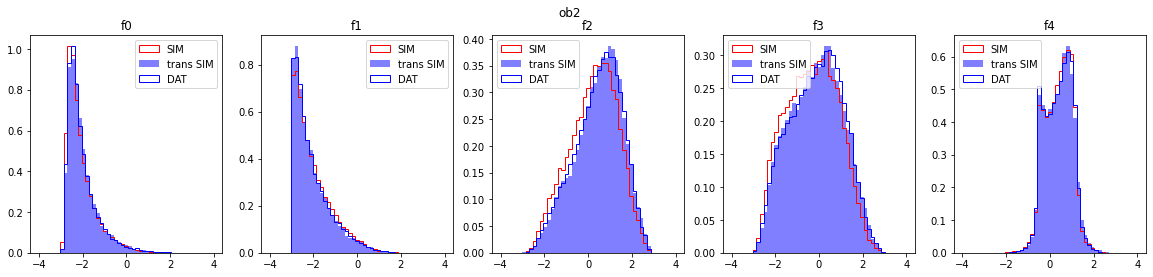

In [7]:
# Apply the flow to data
sim_samples, transformed_sim_samples, dat_samples = make_trans_samples_dict(list(bands_dict.keys()), bands_dict,dataset_sim, dataset_dat, flow_s2d, device)
# Plot all the samples
   
bands_to_plot = list(bands_dict.keys())

n_features = sim_samples[bands_to_plot[0]].shape[-1]

alpha = 0.5
    
for band in bands_to_plot:

    fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 4))
    for i in range(n_features):

        ax[i].hist(sim_samples[band][:,i], bins = binning_scheme, label = "SIM", histtype = "step", color = "red", density = True)
        ax[i].hist(transformed_sim_samples[band][:,i], bins = binning_scheme, label = "trans SIM", alpha = alpha, color = "blue", density = True)
        ax[i].hist(dat_samples[band][:,i], bins = binning_scheme, label = "DAT", histtype = "step", color = "blue", density = True)
        ax[i].legend()
        ax[i].set_title(f"f{i}")
    fig.suptitle(band)      

    fig.show()


In [19]:
hyperparameters_dict_eval = {"n_epochs": 200,
                          "batch_size": 128,
                          "lr": 0.0005,
                          "num_bootstrap": 10,
                            "patience": 10}

epochs_NN = hyperparameters_dict_eval["n_epochs"]
batch_size_NN = hyperparameters_dict_eval["batch_size"]
lr_NN = hyperparameters_dict_eval["lr"]
patience_NN = hyperparameters_dict_eval["patience"]


In [20]:
n_repeat = 10


band_rocs = {band:[] for band in list(bands_dict.keys())}
for band in bands_dict.keys():
    print("Analyzing band", band, "...")
    for j in range(n_repeat):
        roc = analyze_band_transform(band, transformed_sim_samples[band], dat_samples[band], 5, epochs_NN, batch_size_NN, lr_NN, patience_NN, device)
        band_rocs[band].append(roc)
for band in bands_dict.keys():
    mean, lower, upper = get_bootstrapped_AUC(band_rocs[band], lower_percentile = 5, upper_percentile = 95, num_decimals = 6)
    print(band, "roc:", mean, lower, upper)
print()
        

Analyzing band ob1 ...


 18%|█▊        | 36/200 [00:57<04:22,  1.60s/it]


Analyzing band sb1 ...


 12%|█▎        | 25/200 [00:30<03:36,  1.24s/it]


Analyzing band sr ...


 12%|█▏        | 24/200 [00:22<02:43,  1.08it/s]


Analyzing band sb2 ...


  8%|▊         | 15/200 [00:10<02:13,  1.38it/s]


Analyzing band ob2 ...


 14%|█▍        | 28/200 [00:14<01:27,  1.98it/s]

ob1 roc: 0.521201 0.515726 0.525737
sb1 roc: 0.50402 0.500169 0.510374
sr roc: 0.511295 0.502971 0.519255
sb2 roc: 0.507545 0.501247 0.519499
ob2 roc: 0.520554 0.513876 0.529415



## Analyze 1 feature at a time

In [21]:
n_repeat = 10



for i in range(n_features):
    feats_to_choose = [i]
    print("Analyzing features", feats_to_choose, "only...")
    band_rocs = {band:[] for band in list(bands_dict.keys())}
    for band in bands_dict.keys():
        print("Analyzing band", band, "...")
        for j in range(n_repeat):
            roc = analyze_band_transform(band, transformed_sim_samples[band][:,feats_to_choose], dat_samples[band][:,feats_to_choose], len(feats_to_choose), epochs_NN, batch_size_NN, lr_NN, patience_NN, device)
            band_rocs[band].append(roc)
    for band in bands_dict.keys():
        mean, lower, upper = get_bootstrapped_AUC(band_rocs[band], lower_percentile = 5, upper_percentile = 95, num_decimals = 6)
        print(band, "roc:", mean, lower, upper)
    print()
        
        

Analyzing features [0] only...
Analyzing band ob1 ...


 14%|█▍        | 28/200 [00:49<05:02,  1.76s/it]


Analyzing band sb1 ...


  8%|▊         | 16/200 [00:19<03:47,  1.23s/it]


Analyzing band sr ...


  9%|▉         | 18/200 [00:16<02:49,  1.07it/s]


Analyzing band sb2 ...


 14%|█▎        | 27/200 [00:18<01:58,  1.46it/s]


Analyzing band ob2 ...


  8%|▊         | 15/200 [00:07<01:37,  1.90it/s]


ob1 roc: 0.508719 0.5019 0.51384
sb1 roc: 0.503421 0.5001 0.507077
sr roc: 0.509888 0.50541 0.512542
sb2 roc: 0.504949 0.5013 0.511582
ob2 roc: 0.509189 0.502609 0.520402

Analyzing features [1] only...
Analyzing band ob1 ...


 14%|█▎        | 27/200 [00:43<04:40,  1.62s/it]


Analyzing band sb1 ...


 12%|█▏        | 24/200 [00:29<03:36,  1.23s/it]


Analyzing band sr ...


 12%|█▏        | 24/200 [00:22<02:43,  1.08it/s]


Analyzing band sb2 ...


  6%|▌         | 11/200 [00:07<02:16,  1.39it/s]


Analyzing band ob2 ...


 12%|█▎        | 25/200 [00:14<01:39,  1.76it/s]


ob1 roc: 0.509916 0.50418 0.515242
sb1 roc: 0.503487 0.500524 0.507966
sr roc: 0.504294 0.501113 0.508562
sb2 roc: 0.507043 0.503924 0.511684
ob2 roc: 0.505472 0.500868 0.510973

Analyzing features [2] only...
Analyzing band ob1 ...


 14%|█▍        | 28/200 [00:50<05:10,  1.81s/it]


Analyzing band sb1 ...


 14%|█▍        | 29/200 [00:36<03:38,  1.28s/it]


Analyzing band sr ...


 14%|█▍        | 28/200 [00:27<02:45,  1.04it/s]


Analyzing band sb2 ...


  6%|▋         | 13/200 [00:09<02:20,  1.33it/s]


Analyzing band ob2 ...


 18%|█▊        | 37/200 [00:18<01:21,  2.00it/s]


ob1 roc: 0.508869 0.503444 0.514112
sb1 roc: 0.502606 0.500036 0.507053
sr roc: 0.503714 0.501093 0.508489
sb2 roc: 0.506131 0.500634 0.511964
ob2 roc: 0.505676 0.502393 0.509834

Analyzing features [3] only...
Analyzing band ob1 ...


  8%|▊         | 16/200 [00:26<05:08,  1.67s/it]


Analyzing band sb1 ...


  8%|▊         | 15/200 [00:25<05:11,  1.69s/it]


Analyzing band sr ...


 10%|█         | 21/200 [00:26<03:44,  1.26s/it]


Analyzing band sb2 ...


 12%|█▎        | 25/200 [00:24<02:51,  1.02it/s]


Analyzing band ob2 ...


  6%|▌         | 12/200 [00:08<02:13,  1.41it/s]


ob1 roc: 0.504344 0.500896 0.511542
sb1 roc: 0.503165 0.500939 0.505907
sr roc: 0.503742 0.500821 0.507194
sb2 roc: 0.506715 0.502042 0.513225
ob2 roc: 0.506774 0.500595 0.513528

Analyzing features [4] only...
Analyzing band ob1 ...


  9%|▉         | 18/200 [00:40<06:54,  2.28s/it]


Analyzing band sb1 ...


 12%|█▏        | 24/200 [00:46<05:44,  1.96s/it]


Analyzing band sr ...


  6%|▌         | 12/200 [00:17<04:41,  1.50s/it]


Analyzing band sb2 ...


  7%|▋         | 14/200 [00:14<03:07,  1.01s/it]


Analyzing band ob2 ...


  6%|▋         | 13/200 [00:09<02:13,  1.40it/s]

ob1 roc: 0.506267 0.502895 0.509271
sb1 roc: 0.503531 0.501513 0.506467
sr roc: 0.50383 0.500592 0.507653
sb2 roc: 0.502924 0.500122 0.507925
ob2 roc: 0.507943 0.501226 0.514276



## Analyze all but 1 feature

In [ ]:
n_repeat = 10




for i in range(n_features):
    feats_to_choose = [0,1,2,3,4]
    feats_to_choose.remove(i)
    print("Analyzing features", feats_to_choose, "only...")
    band_rocs = {band:[] for band in list(bands_dict.keys())}
    for band in bands_dict.keys():
        print("Analyzing band", band, "...")
        for j in range(n_repeat):
            roc = analyze_band_transform(band, transformed_sim_samples[band][:,feats_to_choose], dat_samples[band][:,feats_to_choose], len(feats_to_choose), epochs_NN, batch_size_NN, lr_NN, patience_NN, device)
            band_rocs[band].append(roc)
    for band in bands_dict.keys():
        mean, lower, upper = get_bootstrapped_AUC(band_rocs[band], lower_percentile = 5, upper_percentile = 95, num_decimals = 6)
        print(band, "roc:", mean, lower, upper)
    print()
        

Analyzing features [1, 2, 3, 4] only...
Analyzing band ob1 ...


 14%|█▍        | 29/200 [01:00<05:57,  2.09s/it]